In [7]:
# ================================================================
# 1. Install Required Libraries (Run Only Once)
# ================================================================
%pip install -q xgboost scikit-learn pandas matplotlib seaborn joblib



Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [8]:
# ================================================================
# 2. Import Libraries
# ================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from xgboost import XGBRegressor
import joblib
import warnings
warnings.filterwarnings("ignore")

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)


In [10]:
# ================================================================
# 3. Load Separate Training and Test Dataset from GitHub RAW URL
# ================================================================

TRAIN_URL = "https://raw.githubusercontent.com/cyriannechabert/datascience_GradApp_predictor/main/train.csv"
TEST_URL  = "https://raw.githubusercontent.com/cyriannechabert/datascience_GradApp_predictor/main/test.csv"


# Example format:
# TRAIN_URL = "https://raw.githubusercontent.com/username/repo/main/train.csv"

train_df = pd.read_csv(TRAIN_URL)
test_df  = pd.read_csv(TEST_URL)

print("Train Shape:", train_df.shape)
print("Test Shape:", test_df.shape)

display(train_df.head())
display(test_df.head())

Train Shape: (700, 8)
Test Shape: (300, 8)


,GRE Score,TOEFL Score,University Rating,SOP,LOR,GPA,Research,Chance of Admit
0,295,96,2,4.9,1.7,2.93,0,0.612
1,340,119,3,4.1,1.7,3.76,0,0.708
2,336,96,1,3.2,1.8,3.12,1,0.728
3,337,108,4,3.4,1.3,2.11,0,0.643
4,323,98,1,1.1,1.3,3.40,0,0.524


,GRE Score,TOEFL Score,University Rating,SOP,LOR,GPA,Research,Chance of Admit
0,325,95,2,4.3,4.4,3.86,0,0.695
1,309,102,2,2.1,4.1,3.77,1,0.801
2,317,110,1,4.9,2.3,2.98,0,0.574
3,297,102,5,4.2,2.3,3.10,0,0.679
4,311,113,1,3.5,4.8,2.04,0,0.609


In [11]:
# ================================================================
# 4. Clean Column Names (remove spaces)
# ================================================================
train_df.columns = train_df.columns.str.strip()
test_df.columns  = test_df.columns.str.strip()

print("\nCleaned Columns:", train_df.columns.tolist())



Cleaned Columns: ['GRE Score', 'TOEFL Score', 'University Rating', 'SOP', 'LOR', 'GPA', 'Research', 'Chance of Admit']


In [12]:
# ================================================================
# 5. Identify Feature & Target Columns
# ================================================================
feature_cols = ["GRE Score", "TOEFL Score", "University Rating",
                "SOP", "LOR", "GPA", "Research"]

target_col = "Chance of Admit"

X_train = train_df[feature_cols]
y_train = train_df[target_col]

X_test  = test_df[feature_cols]
y_test  = test_df[target_col]

print("\nX_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_test :", X_test.shape)
print("y_test :", y_test.shape)





X_train: (700, 7)
y_train: (700,)
X_test : (300, 7)
y_test : (300,)


In [13]:
# ================================================================
# 6. Build & Train Baseline XGBoost Pipeline
# ================================================================
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("xgb", XGBRegressor(
        objective="reg:squarederror",
        random_state=RANDOM_SEED,
        n_jobs=-1
    ))
])

pipeline.fit(X_train, y_train)
y_pred_baseline = pipeline.predict(X_test)


In [14]:
# ================================================================
# 7. Evaluation Function
# ================================================================
def evaluate(y_true, y_pred, title="Model Performance"):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae  = mean_absolute_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)

    print(f"\n===== {title} =====")
    print(f"RMSE : {rmse:.4f}")
    print(f"MAE  : {mae:.4f}")
    print(f"R²   : {r2:.4f}")

# Evaluate baseline model
evaluate(y_test, y_pred_baseline, "Baseline XGBoost")





===== Baseline XGBoost =====
RMSE : 0.0381
MAE  : 0.0309
R²   : 0.8619


In [15]:
# ================================================================
# 8. Hyperparameter Tuning (RandomizedSearchCV)
# ================================================================
param_grid = {
    "n_estimators": [100, 200, 300, 500],
    "max_depth": [3, 4, 5, 6, 8],
    "learning_rate": [0.01, 0.03, 0.05, 0.1, 0.2],
    "subsample": [0.6, 0.7, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.7, 0.8, 1.0],
}

xgb_model = XGBRegressor(
    objective="reg:squarederror",
    random_state=RANDOM_SEED
)

search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_grid,
    n_iter=30,
    scoring="neg_mean_squared_error",
    cv=4,
    random_state=RANDOM_SEED,
    n_jobs=-1,
    verbose=1
)

print("\nHyperparameter tuning started...")
search.fit(X_train, y_train)

best_model = search.best_estimator_
print("\nBest Parameters:", search.best_params_)

# Predict with tuned model
y_pred_tuned = best_model.predict(X_test)

# Evaluate tuned model
evaluate(y_test, y_pred_tuned, "Tuned XGBoost")


Hyperparameter tuning started...
Fitting 4 folds for each of 30 candidates, totalling 120 fits

Best Parameters: {'subsample': 0.6, 'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.05, 'colsample_bytree': 0.6}

===== Tuned XGBoost =====
RMSE : 0.0328
MAE  : 0.0266
R²   : 0.8977


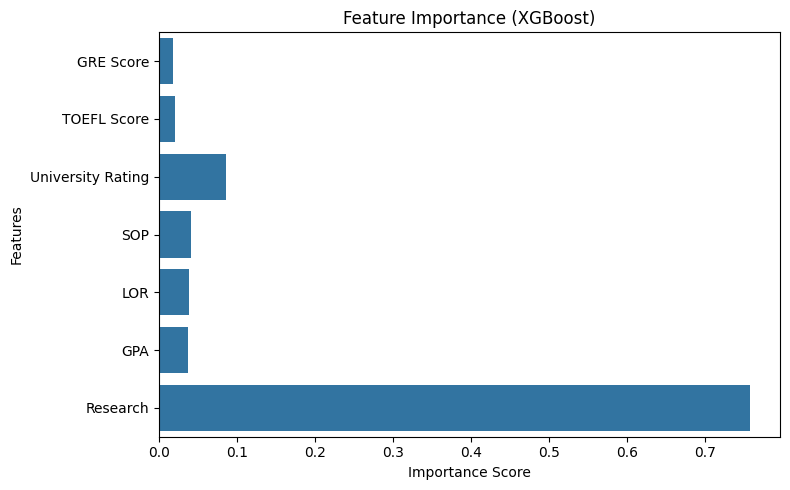

In [16]:
# ================================================================
# 9. Feature Importance Plot
# ================================================================
plt.figure(figsize=(8,5))
sns.barplot(
    x=best_model.feature_importances_,
    y=X_train.columns
)
plt.title("Feature Importance (XGBoost)")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.tight_layout()
plt.show()



In [17]:
# ================================================================
# 10. Save Final Trained Model
# ================================================================
joblib.dump(best_model, "xgb_grad_admission_model.joblib")
print("\nModel saved as xgb_grad_admission_model.joblib")



Model saved as xgb_grad_admission_model.joblib


In [23]:
# ================================================================
# 11. Example Prediction on New Student
# ================================================================
sample_student = pd.DataFrame([{
    "GRE Score": 308,
    "TOEFL Score": 105,
    "University Rating": 3,
    "SOP": 4.0,
    "LOR": 3.0,
    "GPA": 3.70,
    "Research": 1
}])

sample_student = sample_student[X_train.columns]  # match order

chance = best_model.predict(sample_student)[0]
print(f"\nPredicted Chance of Admit = {chance:.4f}")


Predicted Chance of Admit = 0.8648
